In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from scipy.misc import logsumexp
import pdb

In [62]:
class MixModel(object):
    def __init__(self,X,K=10,alpha=1.,mu0=0.,sigma0=1.,sigma=1.):
        self.X = X
        self.N,self.D = X.shape
        self.K=K
        self.alpha = alpha
        self.mu0 = mu0
        self.sigma0 = sigma0
        self.sigma = sigma
        self.Z = np.random.randint(self.K,size=self.N)
        self.mk = np.zeros(self.K)
        self.sum_x = {}
        for k in range(self.K):
            self.sum_x[k] = np.zeros(self.D)
        for n in range(self.N):
            self.add_item(n,self.Z[n])
            
    def add_item(self,i,k):
        self.sum_x[k]+=self.X[i,:]
        self.Z[i]=k
        self.mk[k]+=1
        
    def del_item(self,i):
        k = self.Z[i]
        self.sum_x[k]-=self.X[i,:]
        self.mk[k]-=1
        
    
    def sample_zi(self,i):
        self.del_item(i)
        lprior = np.log(self.alpha + self.mk)
        llik = np.zeros(self.K)
        for k in range(self.K):
            post_var = 1./(1./self.sigma0 + self.mk[k]/self.sigma)
            post_mean = self.mu0/self.sigma0 + self.sum_x[k]/self.sigma
            post_mean = post_mean* post_var
            
            llik[k] = ss.multivariate_normal.logpdf(self.X[i,:],mean=post_mean, cov = np.eye(self.D)*(post_var + self.sigma))
            
        
        ll = lprior + llik
        ll -=logsumexp(ll)
        
        k_new = np.random.multinomial(1,np.exp(ll)).argmax()
        self.add_item(i,k_new)
        
    def sample(self, num_iters=1000,burnin = 500,sampleEvery = 10,verbose=False):
        samples = {}
        for it in range(num_iters):
            for n in range(self.N):
                self.sample_zi(n)
            if it%sampleEvery==0:
                if verbose:
                    print('.')
                if it>burnin:
                
                    samples[it] = self.Z+0
        return samples
            
                
    
    

In [47]:
mu = np.array([[0.,0.],[2.,3.],[4.,1.]])
N=200
Z_true = np.random.randint(3,size=N)
Z_true = np.sort(Z_true)
X = np.zeros((N,2))
for i in range(N):
    X[i,:] = np.random.normal(mu[Z_true[i],:])

In [48]:
model = MixModel(X,K=3)

In [54]:
samples = model.sample()

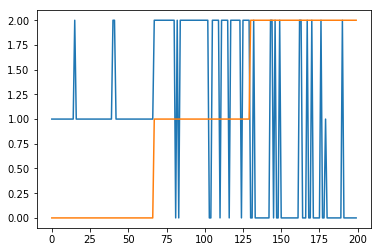

In [55]:
plt.plot(samples[990])
plt.plot(Z_true)
plt.show()

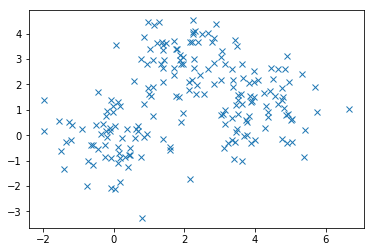

In [56]:
plt.plot(X[:,0],X[:,1],'x')
plt.show()

In [67]:
X_mnist = np.genfromtxt('/Users/williamsons/Teaching/GradCourse/data/score_mnist_small.csv',delimiter=',')
X_mnist.shape

(1000, 50)

In [68]:
model_mnist = MixModel(X_mnist,K=10)

In [69]:
samples = model_mnist.sample(num_iters = 100,burnin=20,verbose=True)

.
.
.
.
.
.
.
.
.
.


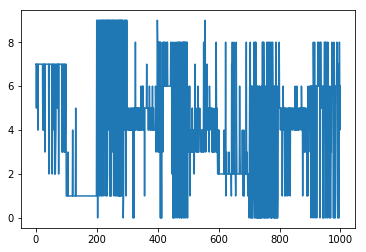

In [71]:
plt.plot(samples[90])
plt.show()


In [74]:
coeff_mnist = np.genfromtxt('/Users/williamsons/Teaching/GradCourse/data/coeff_mnist_small.csv',delimiter=',')



In [79]:
mean_score = {}
mean_pic = {}
for k in range(10):
    mean_score[k] = model_mnist.sum_x[k]/model_mnist.mk[k]

    mean_pic[k] = np.dot(mean_score[k],coeff_mnist.T).reshape(28,28)

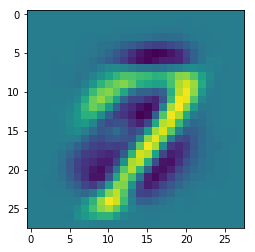

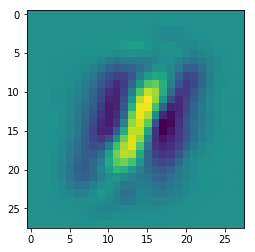

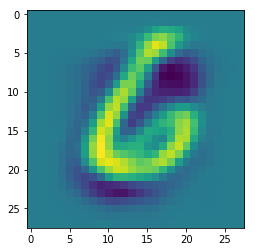

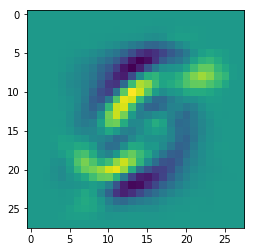

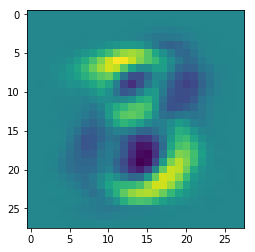

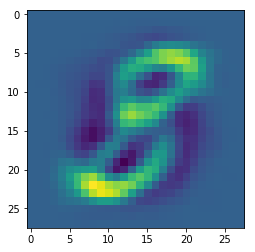

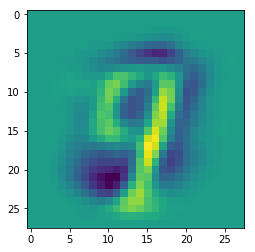

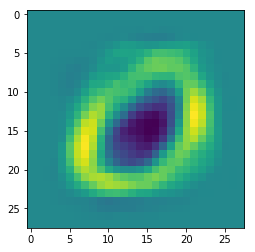

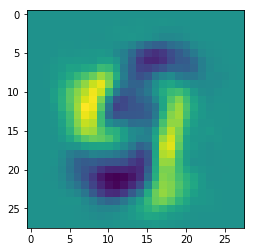

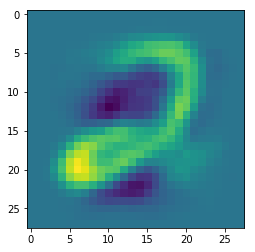

In [80]:
for k in range(10):
    plt.imshow(mean_pic[k])
    plt.show()

In [89]:
class MixModelMult(object):
    def __init__(self,docs,vocab,K=10,alpha=1.,beta=0.1):
        self.docs = docs
        self.vocab = vocab
        self.N,self.V = docs.shape
        self.K=K
        self.alpha = alpha
        self.beta =beta
        self.Z = np.random.randint(self.K,size=self.N)
        self.mk = np.zeros(self.K)
        self.sum_words = {}
        for k in range(self.K):
            self.sum_words[k] = np.zeros(self.V)
        for n in range(self.N):
            self.add_doc(n,self.Z[n])
            
    def add_doc(self,i,k):
        self.sum_words[k]+=self.docs[i,:]
        self.Z[i]=k
        self.mk[k]+=1
        
    def del_doc(self,i):
        k = self.Z[i]
        self.sum_words[k]-=self.docs[i,:]
        self.mk[k]-=1
        
    
    def sample_zi(self,i):
        self.del_doc(i)
        lprior = np.log(self.alpha + self.mk)
        llik = np.zeros(self.K)
        for k in range(self.K):
            post_param = self.beta + self.sum_words[k]
            post_param = post_param/np.sum(post_param)
            
            llik[k] = np.sum(self.docs[i,:]*np.log(post_param)#ss.multinomial.logpmf(self.docs[i,:],n=np.sum(self.docs[i,:]),p=post_param)
            
        
        ll = lprior + llik
        ll -=logsumexp(ll)
        
        k_new = np.random.multinomial(1,np.exp(ll)).argmax()
        self.add_doc(i,k_new)
        
    def sample(self, num_iters=1000,burnin = 500,sampleEvery = 10,verbose=False):
        samples = {}
        for it in range(num_iters):
            for n in range(self.N):
                self.sample_zi(n)
            if it%sampleEvery==0:
                if verbose:
                    print('.')
                if it>burnin:
                
                    samples[it] = self.Z+0
        return samples
            
    def top_n_words(self,k,n=10):
        top_word_ids = self.sum_words[k].argsort()[::-1]
        top_word_ids = top_word_ids[:n]
        top_words = self.vocab[top_word_ids]
        return top_words
    
    

In [90]:
cora = np.genfromtxt('/Users/williamsons/Teaching/GradCourse/data/cora.csv',delimiter=',')

cora_vocab = np.genfromtxt('/Users/williamsons/Teaching/GradCourse/data/cora_vocab.csv',delimiter=',')


In [91]:
mmm = MixModelMult(cora,cora_vocab)

In [92]:
mmm.sample(num_iters=100,burnin=20, verbose=True)

/Users/williamsons/anaconda3/lib/python3.6/site-packages/scipy/stats/_multivariate.py:2810: RuntimeWarning: invalid value encountered in less_equal
  pcond = np.any(p <= 0, axis=-1)
/Users/williamsons/anaconda3/lib/python3.6/site-packages/scipy/stats/_multivariate.py:2811: RuntimeWarning: invalid value encountered in greater
  pcond |= np.any(p > 1, axis=-1)


.
.
.
.
.
.
.
.
.
.


{30: array([1, 1, 1, ..., 1, 1, 1]),
 40: array([1, 1, 1, ..., 1, 1, 1]),
 50: array([1, 1, 1, ..., 1, 1, 1]),
 60: array([1, 1, 1, ..., 1, 1, 1]),
 70: array([1, 1, 1, ..., 1, 1, 1]),
 80: array([1, 1, 1, ..., 1, 1, 1]),
 90: array([1, 1, 1, ..., 1, 1, 1])}